In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# Drug Score Prediction Based on Customer Reviews

In [ ]:
train = pd.read_csv("drugLibTrain_raw.tsv", sep = '\t')
test = pd.read_csv("drugLibTest_raw.tsv", sep = '\t')

In [ ]:
train.rename(columns={'Unnamed: 0':'uniqueID'}, inplace=True )
test.rename(columns={'Unnamed: 0':'uniqueID'}, inplace=True )

In [ ]:
print("Shape of train:", train.shape)
print("Shape of test:", test.shape)

Shape of train: (3107, 9)
Shape of test: (1036, 9)


In [ ]:
data = pd.concat([train, test],axis=0).reset_index()
data.drop('index', axis=1, inplace=True) 

In [ ]:
group = data.groupby(["condition","urlDrugName","uniqueID"]).agg({"rating":"first"})
group

rating
condition                  urlDrugName uniqueID        
1mg                        propecia    2344           9
2                          aricept     3417           9
2 broken arms              mobic       4084           9
2 compressed discs in neck tramadol    2922           9
20 year pack a day smoker  chantix     4113          10
...                                                 ...
yeast infection            diflucan    2524           8
                                       2525           3
                           fluconazole 3597           9
                                       3598           2
                                       3599           7

[4142 rows x 1 columns]

In [ ]:
data.describe()

,uniqueID,rating
count,4143.000000,4143.000000
mean,2081.808834,6.946416
std,1202.018138,2.948868
min,0.000000,1.000000
25%,1041.500000,5.000000
50%,2083.000000,8.000000
75%,3123.500000,9.000000
max,4161.000000,10.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uniqueID           4143 non-null   int64 
 1   urlDrugName        4143 non-null   object
 2   rating             4143 non-null   int64 
 3   effectiveness      4143 non-null   object
 4   sideEffects        4143 non-null   object
 5   condition          4142 non-null   object
 6   benefitsReview     4143 non-null   object
 7   sideEffectsReview  4141 non-null   object
 8   commentsReview     4135 non-null   object
dtypes: int64(2), object(7)
memory usage: 291.4+ KB


In [ ]:
data.isnull().any()

uniqueID             False
urlDrugName          False
rating               False
effectiveness        False
sideEffects          False
condition             True
benefitsReview       False
sideEffectsReview     True
commentsReview        True
dtype: bool

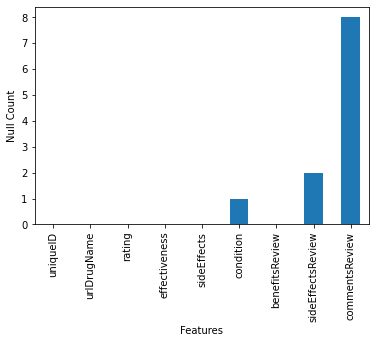

In [ ]:
null_plot = data.isnull().sum().plot.bar()
null_plot = plt.ylabel("Null Count")
null_plot = plt.xlabel("Features")

In [ ]:
data = data.dropna()

In [ ]:
data_enc = pd.get_dummies(data, columns = ["effectiveness"])

In [ ]:
data_enc_final = pd.get_dummies(data_enc, columns = ["sideEffects"])
data_enc_final

,uniqueID,urlDrugName,rating,condition,benefitsReview,sideEffectsReview,commentsReview,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,2202,enalapril,4,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",0,1,0,0,0,0,1,0,0,0
1,3117,ortho-tri-cyclen,1,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",0,1,0,0,0,0,0,0,0,1
2,1146,ponstel,10,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,0,1,0,0,0,0,0,0,1,0
3,3947,prilosec,3,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,0,0,0,1,0,0,1,0,0,0
4,1951,lyrica,2,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,690,accutane,7,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...,1,0,0,0,0,0,0,0,0,1
4139,1071,proair-hfa,10,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...,0,1,0,0,0,0,0,0,1,0
4140,681,accutane,8,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ...",1,0,0,0,0,0,0,1,0,0
4141,2709,divigel,10,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...,0,1,0,0,0,0,0,0,1,0


In [ ]:
categorical = data_enc_final.loc[:,"effectiveness_Considerably Effective":"sideEffects_Severe Side Effects"]

In [ ]:
condition = data_enc_final["condition"]
drugName = data_enc_final["urlDrugName"]
rating = data_enc_final["rating"]

## Data Cleaning

In [ ]:
# Main Data Cleaning Functions
def remove_unrelated(document):
    clean = re.sub("[^a-zA-Z0-9]+", " ", document)
    return clean

def get_text(texts):
    Body = BeautifulSoup(texts, 'lxml').get_text()
    return Body

def clean_data(raw):
    lower = raw.lower()
    no_punc = ''.join([character for character in lower if character not in punctuation])
    no_dig = ''.join([character for character in no_punc if not character.isdigit()])
    return no_dig

In [ ]:
data['benefitsReview'] = data['benefitsReview'].apply(remove_unrelated)
data['sideEffectsReview'] = data['sideEffectsReview'].apply(remove_unrelated)
data['commentsReview'] = data['commentsReview'].apply(remove_unrelated)
data['benefitsReview'] = data['benefitsReview'].apply(get_text)
data['sideEffectsReview'] = data['sideEffectsReview'].apply(get_text)
data['commentsReview'] = data['commentsReview'].apply(get_text)
data['benefitsReview'] = data['benefitsReview'].apply(clean_data)
data['sideEffectsReview'] = data['sideEffectsReview'].apply(clean_data)
data['commentsReview'] = data['commentsReview'].apply(clean_data)
data['benefitsReview'] = data['benefitsReview'].replace('  ',' ',regex=True)
data['sideEffectsReview'] = data['sideEffectsReview'].replace('  ',' ',regex=True)
data['commentsReview'] = data['commentsReview'].replace('  ',' ',regex=True)

In [ ]:
data

,uniqueID,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,cough hypotension proteinuria impotence renal ...,monitor blood pressure weight and asses for re...
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,although this type of birth control has more c...,heavy cycle cramps hot flashes fatigue long la...,i hate this birth control i would not suggest ...
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,i was used to having cramps so badly that they...,heavier bleeding and clotting than normal,i took pills at the onset of my menstrual cram...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,the acid reflux went away for a few months aft...,constipation dry mouth and some mild dizziness...,i was given prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,i think that the lyrica was starting to help w...,i felt extremely drugged and dopey could not d...,see above
...,...,...,...,...,...,...,...,...,...
4138,690,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,detoxing effect by pushing out the system thro...,hairloss extreme dry skin itchiness raises cho...,treatment period is months weeks dosage is tab...
4139,1071,proair-hfa,10,Highly Effective,No Side Effects,asthma,the albuterol relieved the constriction irrita...,i have experienced no side effects,i use the albuterol as needed because of aller...
4140,681,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,serve acne has turned to middle,painfull muscles problems with seeing at night,this drug is highly teratogenic females must t...
4141,2709,divigel,10,Highly Effective,No Side Effects,menopause,my overall mood sense of well being energy lev...,no side effects of any kind were noted or appa...,divigel is a topically applied bio identical h...


### Tokenization

In [ ]:
benefitsReview_token = data['benefitsReview'].apply(word_tokenize)
sideEffectsReview_token = data['sideEffectsReview'].apply(word_tokenize)
commentsReview_token = data['commentsReview'].apply(word_tokenize)

### Remove stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
# Negative words in the stop_words are meaningful for the sentiment, so let's keep these words.
not_stop = ["aren't","aren","couldn't","couldn","didn't","didn","doesn't","doesn","don't","don","hadn't","hadn","hasn't","hasn","haven't","haven","isn't","isn","mightn't","mightn",
            "mustn't","mustn","needn't","needn","no","nor","not","shan't","shouldn't","shouldn","wasn't","wasn","weren't","weren","wouldn't","wouldn"]
for i in not_stop:
    stop_words.remove(i)
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'd',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'more',
 'most',
 'my',
 'myself',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 "she's",
 'should',
 "should've",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'unde

In [ ]:
def remove_stopwords(document):
    
    words = [word for word in document if not word in stop_words]
    
    return words

In [ ]:
benefitsReview_nostop = benefitsReview_token.apply(remove_stopwords)
sideEffectsReview_nostop = sideEffectsReview_token.apply(remove_stopwords)
commentsReview_nostop = commentsReview_token.apply(remove_stopwords)

### Stemming

In [ ]:
porter = PorterStemmer()

def stemmer(document):
    
    stemmed_document = [porter.stem(word) for word in document]
    
    return stemmed_document

In [ ]:
benefitsReview_stem = benefitsReview_nostop.apply(stemmer)
sideEffectsReview_stem = sideEffectsReview_nostop.apply(stemmer)
commentsReview_stem = commentsReview_nostop.apply(stemmer)

## The Document Matrix

### Detokenization

In [ ]:
benefitsReview_detoken = benefitsReview_stem.apply(TreebankWordDetokenizer().detokenize)
sideEffectsReview_detoken = sideEffectsReview_stem.apply(TreebankWordDetokenizer().detokenize)
commentsReview_detoken = commentsReview_stem.apply(TreebankWordDetokenizer().detokenize)

In [ ]:
countvec = CountVectorizer(min_df=0.005)
benefitsReview_dtm = countvec.fit_transform(benefitsReview_detoken)
dtm_benefitsReview = pd.DataFrame(benefitsReview_dtm.toarray(), columns=countvec.get_feature_names(), index=data.index)

In [ ]:
sideEffectsReview_dtm = countvec.fit_transform(sideEffectsReview_detoken)
dtm_sideEffectsReview = pd.DataFrame(sideEffectsReview_dtm.toarray(), columns=countvec.get_feature_names(), index=data.index)

In [ ]:
commentsReview_dtm = countvec.fit_transform(commentsReview_detoken)
dtm_commentsReview = pd.DataFrame(commentsReview_dtm.toarray(), columns=countvec.get_feature_names(), index=data.index)

In [ ]:
frequencies1 = dtm_benefitsReview.sum().sort_values(ascending=False)
frequencies2 = dtm_sideEffectsReview.sum().sort_values(ascending=False)
frequencies3 = dtm_commentsReview.sum().sort_values(ascending=False)
print(frequencies1[frequencies1 > 50])

not          1236
take         1091
effect        919
day           867
pain          856
             ... 
birth          51
asthma         51
ago            51
heartburn      51
job            51
Length: 322, dtype: int64


In [ ]:
print(frequencies2[frequencies2 > 50])

effect      1731
side        1586
not         1299
take        1132
day          810
            ... 
concentr      51
frequent      51
arm           51
immedi        51
ever          51
Length: 296, dtype: int64


In [ ]:
print(frequencies3[frequencies3 > 50])

take          2498
day           2312
mg            1785
not           1415
effect        1209
              ... 
remain          51
supplement      51
reliev          51
applic          51
home            51
Length: 398, dtype: int64


### Merge

In [ ]:
benefitsReview_suffix = dtm_benefitsReview.add_suffix('_benefitsReview')
sideEffectsReview_suffix = dtm_sideEffectsReview.add_suffix('_sideEffectsReview')
commentsReview_suffix = dtm_commentsReview.add_suffix('_commentsReview')
y = data['rating']

In [ ]:
X = pd.concat([benefitsReview_suffix, sideEffectsReview_suffix, commentsReview_suffix, categorical], axis = 1)
X

,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,actual_benefitsReview,ad_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4139,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4140,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4141,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=66)

# Modeling

## Random Forest Regression

In [ ]:
##Modeling
grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
               'n_estimators': [500],
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 

rf = RandomForestRegressor()

rf_cv = GridSearchCV(rf, param_grid = grid_values, scoring = 'r2', cv = 10)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [30],
                         'max_features': array([ 200,  288,  377,  466,  555,  644,  733,  822,  911, 1000],
      dtype=int32),
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'n_estimators': [500], 'random_state': [88]},
             scoring='r2')

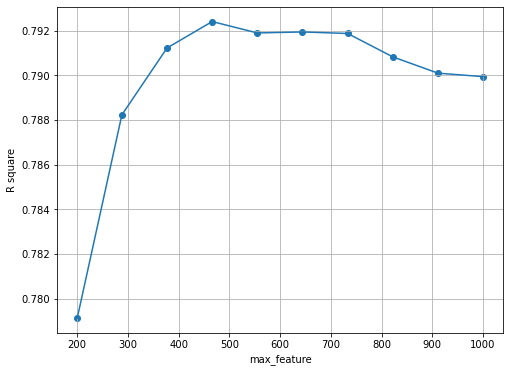

In [ ]:
#Cross validation Plot
r2_rf = rf_cv.cv_results_['mean_test_score']
max_features = rf_cv.cv_results_['param_max_features'].data
plt.figure(figsize = (8,6))
plt.xlabel("max_feature")
plt.ylabel("R square")
plt.scatter(max_features, r2_rf)
plt.plot(max_features, r2_rf)
plt.grid(True, which='both')
plt.show()

In [ ]:
# Best Parameter of Cross Validation
print("This is the best parameters in random forest:", rf_cv.best_params_)
print("This is the highest R square in Cross Validation", rf_cv.best_score_)

This is the best parameters in random forest: {'max_depth': 30, 'max_features': 466, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 88}
This is the highest R square in Cross Validation 0.7924016587942836


In [ ]:
#Feature Importance
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns,
                                      'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)
feature_importance_rf.sort_values(by = ['Importance score'], ascending=False, inplace=True)
feature_importance_rf.head(20)

,Feature,Importance score
1987,effectiveness_Ineffective,17.6
1986,effectiveness_Highly Effective,17.3
1990,sideEffects_Extremely Severe Side Effects,11.5
1994,sideEffects_Severe Side Effects,10.1
1985,effectiveness_Considerably Effective,6.7
1988,effectiveness_Marginally Effective,6.2
1993,sideEffects_No Side Effects,5.4
1991,sideEffects_Mild Side Effects,4.5
1989,effectiveness_Moderately Effective,3.1
1992,sideEffects_Moderate Side Effects,3.0


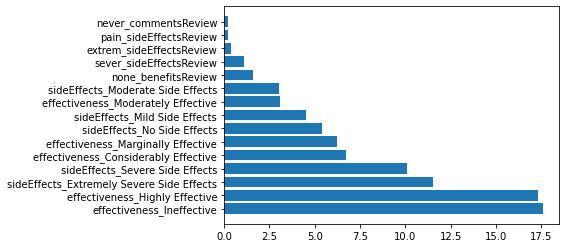

In [ ]:
plt.barh(feature_importance_rf["Feature"].head(15), feature_importance_rf["Importance score"].head(15))
plt.show()

In [ ]:
#Predict using Random Forest 
rf_pred = rf_cv.best_estimator_.predict(X_test)

In [ ]:
#OSR2: Evaluation of Random Forest
r2_rf = r2_score(y_test, rf_pred)
r2_rf

0.7703847280875346

## Decision Tree Regression

In [ ]:
# Decision Tree Regressor
#10-fold cross validation
grid_values_dtr = {'ccp_alpha': np.linspace(0.0, 0.1, 101),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 
            
dtr = DecisionTreeRegressor()
dtr_cv = GridSearchCV(dtr, param_grid = grid_values_dtr, scoring = 'r2', cv=10, verbose=1) 
dtr_cv.fit(X_train, y_train)

Fitting 10 folds for each of 101 candidates, totalling 1010 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.0...
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='r2',

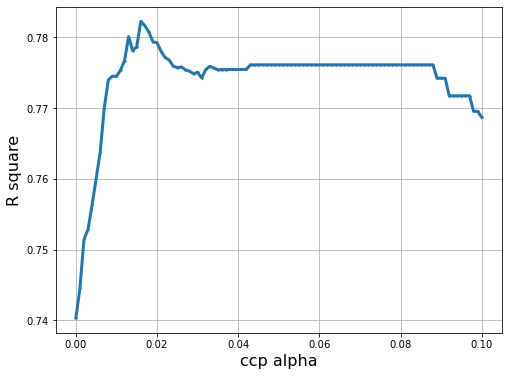

In [ ]:
#Cross validation Plot
ccp = dtr_cv.cv_results_["param_ccp_alpha"].data
r2_dtr = dtr_cv.cv_results_["mean_test_score"]
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('R square', fontsize=16)
plt.scatter(ccp, r2_dtr, s=2)
plt.plot(ccp, r2_dtr, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [ ]:
#Best parameter of Cross Validation
print('The best parameter ccp_alpha (max. R2): ', dtr_cv.best_params_['ccp_alpha'])
print('The best R squared on train set: ', dtr_cv.best_score_)

The best parameter ccp_alpha (max. R2):  0.016
The best R squared on train set:  0.7822575926244564


In [ ]:
#Feature Importance
feature_importance_dtr = pd.DataFrame({'Feature': X_train.columns,
                                      'Importance score': 100*dtr_cv.best_estimator_.feature_importances_}).round(1)
feature_importance_dtr.sort_values(by = ['Importance score'], ascending=False, inplace=True)
feature_importance_dtr.head(30)

,Feature,Importance score
1987,effectiveness_Ineffective,36.0
1986,effectiveness_Highly Effective,21.0
1985,effectiveness_Considerably Effective,12.8
1994,sideEffects_Severe Side Effects,11.1
1990,sideEffects_Extremely Severe Side Effects,10.0
1992,sideEffects_Moderate Side Effects,4.5
1988,effectiveness_Marginally Effective,2.9
1991,sideEffects_Mild Side Effects,0.7
996,not_sideEffectsReview,0.4
1920,told_commentsReview,0.3


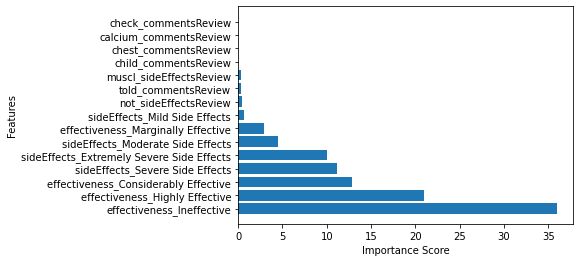

In [ ]:
plt.barh(feature_importance_dtr["Feature"].head(15), 
         feature_importance_dtr["Importance score"].head(15))
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [ ]:
#Predict with Decision Tree Regressor
dtr_pred = dtr_cv.best_estimator_.predict(X_test)

In [ ]:
#Evaluate Decision Tree Regressor on Testing set
r2_dtr = r2_score(y_test, dtr_pred)
print('This is OSR square using Decision Tree Regressor: ', r2_dtr)

This is OSR square using Decision Tree Regressor:  0.7621909754557029


## Gradient Boosting Regression

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=500, ccp_alpha = 0.0001)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(ccp_alpha=0.0001, n_estimators=500)

In [ ]:
#Predict with Gradient Boosting Regressor
gbr_pred = gbr.predict(X_test)

In [ ]:
#Evaluate Gradient Boosting Regressor on Testing set
r2_gbr = r2_score(y_test, gbr_pred)
print('This is OSR square using Gradient Boosting Regressor: ', r2_gbr)

This is OSR square using Gradient Boosting Regressor:  0.7661750457973392


## Model Comparison

In [ ]:
#Baseline Linear Regression
lr = LinearRegression().fit(X_train, y_train)

In [ ]:
# Comparison Table
comparison_data = {'Linear Regression': ['{:.5f}'.format(r2_score(y_test, lr.predict(X_test))),
                                         '{:.5f}'.format(mean_squared_error(y_test, lr.predict(X_test))),
                                         '{:.5f}'.format(mean_absolute_error(y_test, lr.predict(X_test)))],
                   'Decision Tree Regression': ['{:.5f}'.format(r2_score(y_test, dtr_pred)),
                                               '{:.5f}'.format(mean_squared_error(y_test, dtr_pred)),
                                               '{:.5f}'.format(mean_absolute_error(y_test, dtr_pred))],
                   'Random Forest': ['{:.5f}'.format(r2_score(y_test, rf_pred)),
                                     '{:.5f}'.format(mean_squared_error(y_test, rf_pred)),
                                     '{:.5f}'.format(mean_absolute_error(y_test, rf_pred))], 
                   'Gradient Boosting Regression': ['{:.5f}'.format(r2_score(y_test, gbr_pred)),
                                              '{:.5f}'.format(mean_squared_error(y_test, gbr_pred)),
                                              '{:.5f}'.format(mean_absolute_error(y_test, gbr_pred))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Out-of-sample MSE', 'Out-of-sample MAE'])
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '12pt')]}])

,Linear Regression,Decision Tree Regression,Random Forest,Gradient Boosting Regression
OSR2,0.08300,0.76219,0.77038,0.76618
Out-of-sample MSE,7.74496,2.00854,1.93933,1.97489
Out-of-sample MAE,2.09669,1.01412,1.00341,1.01634


<function matplotlib.pyplot.show(close=None, block=None)>

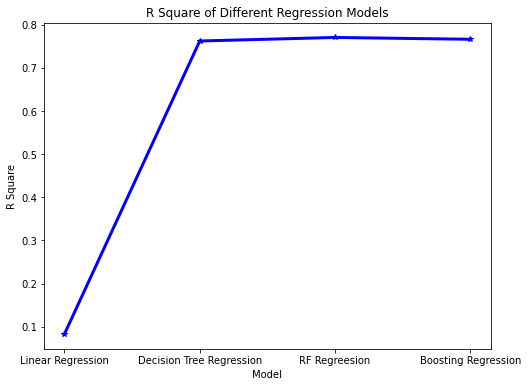

In [ ]:
x = ['Linear Regression','Decision Tree Regression','RF Regreesion','Boosting Regression']
y = [0.08300, 0.76219, 0.77038, 0.76618]
plt.figure(figsize = (8,6))
plt.plot(x, y, linewidth = 3.0, color = 'b', marker = '*')
plt.xlabel("Model")
plt.ylabel("R Square")
plt.title("R Square of Different Regression Models")
plt.show

# Add a new feature resulting from another dataset

Here we get our best **R square = 0.77038**	resuting from the Random Forest model. We want to improve R square by adding a relevant feature resulting from another data set called **drugsCom_raw.tsv**, it is a dataset containing reviews from individual user towards drugs. We appended the processing of the dataset in **Appendix II**, and here we directly used the outcome of that processing part. Please refer to **Appendix II** to see how we get **Rate.csv** and **Number.csv**.

In [ ]:
ratio = pd.read_csv("Rate.csv")
number = pd.read_csv("Number.csv")

In [ ]:
ratio.drop(columns = ["Unnamed: 0"], inplace = True)

In [ ]:
def check_condition(raw_condition):
    if '</span>' in raw_condition:
        return True
    else: 
        return False

In [ ]:
ratio_new = ratio.loc[ratio["condition"].apply(check_condition) == False]

In [ ]:
# ratio_new["drugName"] = ratio_new["drugName"].str.lower()
ratio_new["drugName"] = ratio_new["drugName"].apply(str.lower)

<ipython-input-86-b7007152afdb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_new["drugName"] = ratio_new["drugName"].apply(str.lower)


In [ ]:
ratio_new["condition"] = ratio_new["condition"].apply(str.lower)

<ipython-input-87-502d32251de1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_new["condition"] = ratio_new["condition"].apply(str.lower)


In [ ]:
ratio_new

,condition,drugName,positive_review,negative_review,total_review,positive_review_rate,rate
860,adhd,adderall,215,12,227,0.947137,high
861,adhd,adderall xr,132,7,139,0.949640,high
862,adhd,adzenys xr-odt,18,3,21,0.857143,high
863,adhd,amantadine,3,0,3,1.000000,high
864,adhd,amphetamine,41,13,54,0.759259,high
...,...,...,...,...,...,...,...
9441,zen shoulde,indomethacin,1,0,1,1.000000,high
9442,zen shoulde,nabumetone,3,0,3,1.000000,high
9443,zen shoulde,naproxen,4,0,4,1.000000,high
9444,zen shoulde,relafen,2,0,2,1.000000,high


In [ ]:
ratio_positive = ratio_new.loc[:,["condition","drugName","total_review","positive_review_rate"]]
ratio_positive

,condition,drugName,total_review,positive_review_rate
860,adhd,adderall,227,0.947137
861,adhd,adderall xr,139,0.949640
862,adhd,adzenys xr-odt,21,0.857143
863,adhd,amantadine,3,1.000000
864,adhd,amphetamine,54,0.759259
...,...,...,...,...
9441,zen shoulde,indomethacin,1,1.000000
9442,zen shoulde,nabumetone,3,1.000000
9443,zen shoulde,naproxen,4,1.000000
9444,zen shoulde,relafen,2,1.000000


In [ ]:
second_data = pd.concat([condition, drugName, rating, benefitsReview_suffix, sideEffectsReview_suffix, commentsReview_suffix, categorical], axis = 1)

second_data.rename(columns = {"urlDrugName":"drugName"}, inplace = True)
second_data

,condition,drugName,rating,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,management of congestive heart failure,enalapril,4,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,birth prevention,ortho-tri-cyclen,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,menstrual cramps,ponstel,10,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,acid reflux,prilosec,3,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,fibromyalgia,lyrica,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4138,acne vulgaris,accutane,7,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4139,asthma,proair-hfa,10,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4140,serve acne,accutane,8,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4141,menopause,divigel,10,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## Merge ratio_positive and second_data on "condition" and "drugName"

In [ ]:
merged_1 = pd.merge(ratio_positive, second_data, on = ["condition", "drugName"], how = 'inner')

In [ ]:
merged_1
## A drug has positive review rates in conditions:B,C,D ,
## But it only has data in condition E in the second 

,condition,drugName,total_review,positive_review_rate,rating,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,adhd,adderall,227,0.947137,8,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,adhd,adderall,227,0.947137,10,2,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,adhd,adderall,227,0.947137,10,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,adhd,concerta,257,0.867704,8,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,adhd,concerta,257,0.867704,2,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,weight loss,adipex-p,343,0.944606,6,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1036,weight loss,adipex-p,343,0.944606,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1037,weight loss,adipex-p,343,0.944606,10,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1038,weight loss,adipex-p,343,0.944606,8,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
y_1 = merged_1["rating"]
positive = merged_1.loc[:,"total_review":"positive_review_rate"]
sec = merged_1.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_1 = pd.concat([positive, sec], axis = 1)
X_1

,total_review,positive_review_rate,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,227,0.947137,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,227,0.947137,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,227,0.947137,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,257,0.867704,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,257,0.867704,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,343,0.944606,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1036,343,0.944606,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1037,343,0.944606,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1038,343,0.944606,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
#Split Data into Testing and Training
X_train1, X_test1, y_train1, y_test1  = train_test_split(X_1, y_1, test_size=0.3, random_state=66)
X_train1

,total_review,positive_review_rate,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
66,1,1.000000,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
399,513,0.873294,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
247,34,0.941176,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
594,386,0.829016,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
196,65,0.846154,0,0,0,0,0,2,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,824,0.713592,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
661,7,0.714286,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
51,431,0.923434,0,0,0,0,0,2,0,0,...,0,1,0,0,0,0,1,0,0,0
631,315,0.971429,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
y_train1

66      7
399     2
247     7
594    10
196     8
       ..
307    10
661    10
51      9
631    10
828     9
Name: rating, Length: 728, dtype: int64

In [ ]:
#Random Forest Modeling

# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]} 

rf_1 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                            min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_1.fit(X_train1,y_train1)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
#Predict with Random Forest
pred_rf1 = rf_1.predict(X_test1)

In [ ]:
#Evaluate with RF
r2_rf1 = r2_score(y_test1,pred_rf1)
r2_rf1

0.7252906264908257

In [ ]:
#Decision Tree Regressor

dtr_1 = DecisionTreeRegressor(ccp_alpha = 0.016, min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
# grid_values_dtr = {'ccp_alpha': np.linspace(0.0, 0.1, 101),
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]} 
dtr_1.fit(X_train1, y_train1)

DecisionTreeRegressor(ccp_alpha=0.016, max_depth=30, min_samples_leaf=5,
                      min_samples_split=20, random_state=88)

In [ ]:
pred_dtr1 = dtr_1.predict(X_test1)

In [ ]:
#Evaluate with RF
from sklearn.metrics import r2_score
r2_dtr1 = r2_score(y_test1,pred_dtr1)
r2_dtr1 

0.6229324335589173

**The R score using random forest is a lot lower than before we add these features. So it means the prediction of the previous model is not accurate. Let's try the results from Vader model. Try merging Vader dataset to the whole dataset.**

## Merging Vadar model results with the second data set

In [ ]:
# vader = pd.read_csv("vader.csv")
vader = pd.read_csv("vader.csv")
vader["drugName"] = vader["drugName"].apply(str.lower)
vader["condition"] = vader["condition"].apply(str.lower)
vader

,drugName,condition,mean,sum,count
0,a + d cracked skin relief,bacterial skin infection,1.000000,1,1
1,a / b otic,otitis media,0.000000,0,2
2,abacavir / dolutegravir / lamivudine,hiv infection,0.600000,42,70
3,abacavir / lamivudine,hiv infection,0.666667,2,3
4,abacavir / lamivudine / zidovudine,hiv infection,0.000000,0,1
...,...,...,...,...,...
9441,femhrt,0</span> users found this comment helpful.,0.000000,0,1
9442,femhrt,acne,0.000000,0,2
9443,femhrt,menstrual disorders,1.000000,1,1
9444,femhrt,postmenopausal symptoms,0.500000,1,2


### Try merging on both condition and drugName

In [ ]:
merged_2 = pd.merge(vader, second_data, on = ["condition", "drugName"], how = 'inner')
merged_2.drop(columns = ["count"],inplace = True)
merged_2

,drugName,condition,mean,sum,rating,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,abilify,depression,0.520619,101,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,abilify,depression,0.520619,101,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,abilify,depression,0.520619,101,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,accutane,acne,0.598608,258,9,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,accutane,acne,0.598608,258,8,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,zyban,smoking cessation,0.632911,50,6,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1036,zyban,smoking cessation,0.632911,50,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1037,zyprexa,depression,0.500000,18,10,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1038,zyprexa,schizophrenia,0.900000,18,3,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
y_2 = merged_2["rating"]
positive_2 = merged_2.loc[:,"mean":"sum"]
sec_2 = merged_2.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_2 = pd.concat([positive_2, sec_2], axis = 1)
X_2

,mean,sum,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,0.520619,101,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0.520619,101,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.520619,101,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0.598608,258,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.598608,258,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.632911,50,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1036,0.632911,50,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1037,0.500000,18,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1038,0.900000,18,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
X_train2, X_test2, y_train2, y_test2  = train_test_split(X_2, y_2, test_size=0.3, random_state=66)
X_train2

,mean,sum,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
66,0.467857,262,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
399,0.554688,71,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
247,0.627737,86,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
594,0.538835,444,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
196,0.564202,145,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.693750,111,0,0,0,0,0,2,0,0,...,0,1,0,0,0,0,0,0,1,0
661,0.538462,21,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
51,0.638484,219,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
631,0.367647,50,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]}
rf_2 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                            min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
#Predict and Evaluate with Random Forest
pred_rf2 = rf_2.predict(X_test2)
r2_rf2 = r2_score(y_test2,pred_rf2)
r2_rf2

0.7471550713538733

In [ ]:
## Decision Tree Regressor
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

dtr_2 = DecisionTreeRegressor(ccp_alpha = 0.016, min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
# grid_values_dtr = {'ccp_alpha': np.linspace(0.0, 0.1, 101),
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]} 
dtr_2.fit(X_train2, y_train2)

DecisionTreeRegressor(ccp_alpha=0.016, max_depth=30, min_samples_leaf=5,
                      min_samples_split=20, random_state=88)

In [ ]:
#Predict and Evaluate with Decision Tree
pred_dtr2 = dtr_2.predict(X_test2)
r2_dtr2 = r2_score(y_test2,pred_dtr2)
r2_dtr2

0.722102380489186

**The R2 score is still lower than before. It's probably caused by merging on both condition and drugName and therefore the volume of the dataset is too small. Let's try merging only on drugName and retrain the model**

### Merge on only drugName

In [ ]:
vader_new = vader.groupby(["drugName"], as_index = False).agg({"sum":"sum", "count":"sum"})
vader_new["pos_rate"] = vader_new["sum"]/vader_new["count"]
vader_new["drugName"].unique().size

3667

In [ ]:
# Getting sentiment class for each drug. 
# If positive rate <= 0.33, then negative
# If positive rate > 0.33 & <= 0.66, then neutral
# If positive rate > 0.66, then positive
def get_class(pos_rate):
    if pos_rate <= 0.33:
        return "negative"
    elif (pos_rate > 0.33) & (pos_rate <= 0.67):
        return "neutral"
    else:
        return "positive"
    
vader_new["class"] = vader_new["pos_rate"].apply(get_class)
vader_new

,drugName,sum,count,pos_rate,class
0,a + d cracked skin relief,1,1,1.000000,positive
1,a / b otic,0,2,0.000000,negative
2,abacavir / dolutegravir / lamivudine,42,70,0.600000,neutral
3,abacavir / lamivudine,2,3,0.666667,neutral
4,abacavir / lamivudine / zidovudine,0,1,0.000000,negative
...,...,...,...,...,...
3662,zyrtec-d,2,3,0.666667,neutral
3663,zyrtec-d 12 hour,1,1,1.000000,positive
3664,zytiga,4,12,0.333333,neutral
3665,zyvox,11,23,0.478261,neutral


In [ ]:
##Merge
merged_3 = pd.merge(vader_new, second_data, on = ["drugName"], how = 'inner')

In [ ]:
merged_3.drop("count", axis = 1, inplace = True)

In [ ]:
merged_3

,drugName,sum,pos_rate,class,condition,rating,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,abilify,313,0.527825,neutral,depression not resolved with antidepressant drugs,2,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,abilify,313,0.527825,neutral,depression,6,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,abilify,313,0.527825,neutral,bipolar disorder,3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,abilify,313,0.527825,neutral,depression/anxiety,10,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,abilify,313,0.527825,neutral,bipolar,8,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,zyrtec-d,2,0.666667,neutral,allergies,9,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3701,zyrtec-d,2,0.666667,neutral,hay fever,5,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3702,zyrtec-d,2,0.666667,neutral,"pollen, dust, mold and tree allergies",7,0,3,0,0,...,1,0,0,0,0,0,0,0,1,0
3703,zyrtec-d,2,0.666667,neutral,allergies,7,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0


#### Predict with sentiment class & Positive Rate

In [ ]:
# Using number of positive reviews, Positive rate and Sentiment Class.
y_3 = merged_3["rating"]
positive_3 = merged_3.loc[:,"sum":"class"]
sec_3 = merged_3.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_3 = pd.concat([positive_3, sec_3], axis = 1)

In [ ]:
X_train3, X_test3, y_train3, y_test3  = train_test_split(X_3, y_3, test_size=0.3, random_state=66)
X_train3_dummy = pd.get_dummies(X_train3, columns = ["class"])
X_train3_dummy

,sum,pos_rate,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,...,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects,class_negative,class_neutral,class_positive
1232,43,0.589041,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
292,5,0.384615,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
69,4,0.285714,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2413,5,0.555556,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2002,85,0.472222,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,13,0.309524,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
51,264,0.598639,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
631,4,0.800000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
828,21,0.617647,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
#Random Forest
# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]}
rf_3 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                             min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_3.fit(X_train3_dummy,y_train3)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
#Predict&Evaluate RF
X_test3_dummy = pd.get_dummies(X_test3, columns = ["class"])
pred_rf3 = rf_3.predict(X_test3_dummy)
r2_rf3 = r2_score(y_test3,pred_rf3)
r2_rf3

0.7920209549921066

#### Predict without Sentiment Class (Only Using Positive Rate)

In [ ]:
merged_3

,drugName,sum,pos_rate,class,condition,rating,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,abilify,313,0.527825,neutral,depression not resolved with antidepressant drugs,2,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,abilify,313,0.527825,neutral,depression,6,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,abilify,313,0.527825,neutral,bipolar disorder,3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,abilify,313,0.527825,neutral,depression/anxiety,10,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,abilify,313,0.527825,neutral,bipolar,8,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,zyrtec-d,2,0.666667,neutral,allergies,9,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3701,zyrtec-d,2,0.666667,neutral,hay fever,5,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3702,zyrtec-d,2,0.666667,neutral,"pollen, dust, mold and tree allergies",7,0,3,0,0,...,1,0,0,0,0,0,0,0,1,0
3703,zyrtec-d,2,0.666667,neutral,allergies,7,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
# Using number of positive reviews and Positive rate.
y_4 = merged_3["rating"]
positive_4 = merged_3.loc[:,"sum":"pos_rate"]
sec_4 = merged_3.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_4 = pd.concat([positive_4, sec_4], axis = 1)

In [ ]:
X_train4, X_test4, y_train4, y_test4  = train_test_split(X_4, y_4, test_size=0.3, random_state=66)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]}
rf_4 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                             min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_4.fit(X_train4,y_train4)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
#Predict&Evaluate RF
pred_rf4 = rf_4.predict(X_test4)
r2_rf4 = r2_score(y_test4,pred_rf4)
r2_rf4

0.7920126855403158

#### Predict with only Sentiment Class (Without Positive Ratio)

In [ ]:
# Using number of positive reviews and Positive rate.
y_5 = merged_3["rating"]
positive_5 = merged_3.loc[:,"sum":"class"]
sec_5 = merged_3.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_5 = pd.concat([positive_5, sec_5], axis = 1)
X_5.drop("pos_rate", axis=1, inplace = True)
X_5_dummy = pd.get_dummies(X_5, columns = ["class"])
X_5_dummy

,sum,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,actual_benefitsReview,...,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects,class_negative,class_neutral,class_positive
0,313,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,313,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,313,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,313,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,313,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3701,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3702,2,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3703,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
X_train5, X_test5, y_train5, y_test5  = train_test_split(X_5_dummy, y_5, test_size=0.3, random_state=66)

In [ ]:
#Random Forest
# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]}
rf_5 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                             min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_5.fit(X_train5,y_train5)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
#Predict&Evaluate RF
pred_rf5 = rf_5.predict(X_test5)
r2_rf5 = r2_score(y_test5,pred_rf5)
r2_rf5

0.7912763550432831

Training with positive ratio and the number of positive reviews has the highest out of sample R square. 
<br>Let's use 10-fold cross validation to get the best random forest regression model using positive ratio, number of positive reviews and other features from our original dataset

## Cross-validation for Random Forest using Positive Ratio

In [ ]:
grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
               'n_estimators': [500],
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 

rf_6 = RandomForestRegressor()
rf_cv6 = GridSearchCV(rf_6, param_grid = grid_values, scoring = 'r2', cv = 10)
## X_train4 and y_train4 doesn't have sentiment class, 
## So we use them to train the model
rf_cv6.fit(X_train4, y_train4)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [30],
                         'max_features': array([ 200,  288,  377,  466,  555,  644,  733,  822,  911, 1000],
      dtype=int32),
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'n_estimators': [500], 'random_state': [88]},
             scoring='r2')

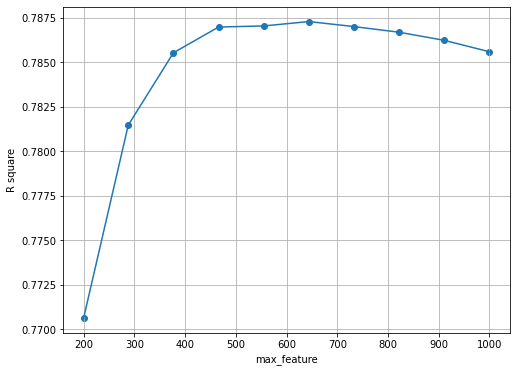

In [ ]:
#Cross validation Plot
r2_rf6 = rf_cv6.cv_results_['mean_test_score']
max_features6 = rf_cv6.cv_results_['param_max_features'].data
plt.figure(figsize = (8,6))
plt.xlabel("max_feature")
plt.ylabel("R square")
plt.scatter(max_features6, r2_rf6)
plt.plot(max_features6, r2_rf6)
plt.grid(True, which='both')
plt.show()

In [ ]:
# Best Parameter of Cross Validation
print("This is the best parameters in random forest:", rf_cv6.best_params_)
print("This is the highest R square in Cross Validation", rf_cv6.best_score_)

This is the best parameters in random forest: {'max_depth': 30, 'max_features': 644, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 88}
This is the highest R square in Cross Validation 0.7872888481369655


In [ ]:
#Feature Importance
feature_importance_rf6 = pd.DataFrame({'Feature': X_train4.columns,
                                      'Importance score': 100*rf_cv6.best_estimator_.feature_importances_}).round(1)
feature_importance_rf6.sort_values(by = ['Importance score'], ascending=False, inplace=True)
feature_importance_rf6.head(20)

,Feature,Importance score
1988,effectiveness_Highly Effective,19.3
1989,effectiveness_Ineffective,15.6
1992,sideEffects_Extremely Severe Side Effects,14.1
1996,sideEffects_Severe Side Effects,11.3
1987,effectiveness_Considerably Effective,7.0
1995,sideEffects_No Side Effects,5.0
1990,effectiveness_Marginally Effective,4.9
1993,sideEffects_Mild Side Effects,3.9
1994,sideEffects_Moderate Side Effects,3.2
1991,effectiveness_Moderately Effective,2.8


In [ ]:
#Predict using Random Forest 
rf_pred6 = rf_cv6.best_estimator_.predict(X_test4)

In [ ]:
#OSR2: Evaluation of Random Forest
from sklearn.metrics import r2_score
r2_rf6 = r2_score(y_test4, rf_pred6)
r2_rf6

0.7937714746930509

## Recommendation with Random Forest

In [ ]:
## Let's use this model to predict ratings for 
## both training and testing data set.
# total_X = pd.concat([X_train4, X_test4], axis = 0, ignore_index = True)
rf_total_pred = rf_cv6.best_estimator_.predict(X_4)
rf_total_pred

array([2.47044518, 7.34209935, 3.4744395 , ..., 8.0545083 , 7.83964682,
       7.87969312])

In [ ]:
## Make recommedation based on model predicted scores
merged_3["rf_pred"] = rf_total_pred
recommend = merged_3.groupby(["condition","drugName"], as_index = False).agg({"rf_pred":"mean"})
recommend.sort_values(by = ["rf_pred"], ascending = False, inplace = True)
recommend

,condition,drugName,rf_pred
791,ed,levitra,9.982928
794,elevated cholesterol,lipitor,9.968440
1082,high colesteral,crestor,9.957029
509,cholesterol,vytorin,9.951452
1204,idiopathic excema,elidel,9.944911
...,...,...,...
547,"chronic pain, fibromyalgia",neurontin,1.116619
1175,hypothyroid,tirosint,1.112213
1790,prevent osteoporose,actonel,1.093275
1099,hives,atarax,1.079551


In [ ]:
multiple = recommend[recommend.groupby('condition')['drugName'].transform('count')>1]
# multiple.sort_values(by = ["rf_pred"], ascending = False,inplace = True)
multiple

,condition,drugName,rf_pred
791,ed,levitra,9.982928
794,elevated cholesterol,lipitor,9.968440
509,cholesterol,vytorin,9.951452
1080,high cholestrol,lipitor,9.940001
1499,muscle spasm,skelaxin,9.936777
...,...,...,...
1939,schizophrenia,risperdal,1.158788
1151,hypertension,inderal,1.128902
470,bronchitis,avelox,1.125982
1175,hypothyroid,tirosint,1.112213


In [ ]:
final = multiple.groupby(["condition","drugName"]).agg({"rf_pred":"mean"})
final = final.sort_values('rf_pred',ascending=False).sort_index(level=0,ascending=[True])
final.head(50)

rf_pred
condition         drugName                   
acid reflux       aciphex            9.607249
                  protonix           9.518263
                  nexium             8.941229
                  zantac             8.597463
                  ranitidine         8.408890
                  prilosec           7.463773
                  prevacid           7.000794
                  zegerid            6.303795
acid reflux, gerd protonix           8.699481
                  nexium             3.587305
                  zegerid            2.442747
acne              finacea            8.309712
                  ampicillin         8.276984
                  benzaclin          8.246398
                  yasmin             8.127946
                  aczone             8.109637
                  ziana              8.104236
                  spironolactone     7.931832
                  accutane           7.564883
                  duac               7.421374
                  avita              7.393096
                  sotret             7.389563
                  doxycycline        7.245553
                  tazorac            6.869659
                  retin-a            6.832462
                  differin           6.765697
                  aldactone          6.730847
                  doryx              6.729350
                  tetracycline       6.584911
                  minocin            6.469858
                  cleocin            6.409789
                  oracea             6.286411
                  minocycline        5.397867
                  azelex             4.787305
                  erythromycin       3.732048
                  solodyn            3.274966
                  kenalog            2.221293
acne rosacea      metrogel           9.864085
                  finacea            6.555924
                  doxycycline        1.468941
actinic keratoses carac              8.167240
                  efudex             4.165658
add               dextrostat         8.925340
                  adderall           8.655569
                  provigil           8.302729
                  amphetamine        8.230703
                  ritalin            8.201031
                  dextroamphetamine  7.860722
                  concerta           7.638204
                  vyvanse            7.630364

## Predict with diffReviews (The difference between the number of positive and negative reviews)

In [ ]:
## Try using differences in number of positive reviews
## and negative reviews to predict
merged_new = pd.merge(vader_new, second_data, on = ["drugName"], how = 'inner')
merged_new.rename(columns = {"sum":"positiveReview"}, inplace = True)
merged_new

,drugName,positiveReview,count,pos_rate,class,condition,rating,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,abilify,313,593,0.527825,neutral,depression not resolved with antidepressant drugs,2,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,abilify,313,593,0.527825,neutral,depression,6,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,abilify,313,593,0.527825,neutral,bipolar disorder,3,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,abilify,313,593,0.527825,neutral,depression/anxiety,10,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,abilify,313,593,0.527825,neutral,bipolar,8,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,zyrtec-d,2,3,0.666667,neutral,allergies,9,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3701,zyrtec-d,2,3,0.666667,neutral,hay fever,5,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3702,zyrtec-d,2,3,0.666667,neutral,"pollen, dust, mold and tree allergies",7,0,3,0,...,1,0,0,0,0,0,0,0,1,0
3703,zyrtec-d,2,3,0.666667,neutral,allergies,7,0,1,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
#Calculate the number of negative review
merged_new.insert(2, "negativeReview", merged_new["count"]-merged_new["positiveReview"], True)

In [ ]:
merged_new.insert(3, "diffReview", merged_new["positiveReview"]-merged_new["negativeReview"], True)

In [ ]:
merged_new.insert(4, "sentiment", ["Positive" if x >=0 else "Negative" for x in merged_new["diffReview"]], True)

In [ ]:
merged_new["diffReview"] = merged_new["diffReview"].apply(abs)
merged_new

,drugName,positiveReview,negativeReview,diffReview,sentiment,count,pos_rate,class,condition,rating,...,effectiveness_Considerably Effective,effectiveness_Highly Effective,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects
0,abilify,313,280,33,Positive,593,0.527825,neutral,depression not resolved with antidepressant drugs,2,...,1,0,0,0,0,1,0,0,0,0
1,abilify,313,280,33,Positive,593,0.527825,neutral,depression,6,...,1,0,0,0,0,0,0,0,1,0
2,abilify,313,280,33,Positive,593,0.527825,neutral,bipolar disorder,3,...,0,0,0,1,0,0,0,0,0,1
3,abilify,313,280,33,Positive,593,0.527825,neutral,depression/anxiety,10,...,0,1,0,0,0,0,0,0,1,0
4,abilify,313,280,33,Positive,593,0.527825,neutral,bipolar,8,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,zyrtec-d,2,1,1,Positive,3,0.666667,neutral,allergies,9,...,0,1,0,0,0,0,1,0,0,0
3701,zyrtec-d,2,1,1,Positive,3,0.666667,neutral,hay fever,5,...,1,0,0,0,0,0,0,1,0,0
3702,zyrtec-d,2,1,1,Positive,3,0.666667,neutral,"pollen, dust, mold and tree allergies",7,...,1,0,0,0,0,0,0,0,1,0
3703,zyrtec-d,2,1,1,Positive,3,0.666667,neutral,allergies,7,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
# Using number of positive reviews and Positive rate.
y_7 = merged_new["rating"]
positive_7 = merged_new.loc[:,"diffReview":"sentiment"]
sec_7 = merged_new.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_7 = pd.concat([positive_7, sec_7], axis = 1)
X_7_dummy = pd.get_dummies(X_7, columns = ["sentiment"])
X_7_dummy

,diffReview,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,actual_benefitsReview,...,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects,sentiment_Negative,sentiment_Positive
0,33,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,33,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,33,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3701,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3702,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3703,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(X_7_dummy, y_7, test_size = 0.3, random_state = 66)
X_train7

,diffReview,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,activ_benefitsReview,actual_benefitsReview,...,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects,sentiment_Negative,sentiment_Positive
1232,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
292,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
69,6,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2413,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2002,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,16,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
51,87,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
631,3,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
828,8,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
#Random Forest Modeling

# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]} 

rf_7 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                            min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_7.fit(X_train7,y_train7)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
pred_rf7 = rf_7.predict(X_test7)
r2_rf7 = r2_score(y_test7,pred_rf7)
r2_rf7

0.7914556784173781

## Predict with diffReviews and Positive rate

In [ ]:
y_8 = merged_new["rating"]
new_8 = merged_new.loc[:,"positiveReview":"class"]
new_8.drop(columns = ["negativeReview","count","class"], axis=1, inplace = True)
sec_8 = merged_new.loc[:,"abil_benefitsReview":"sideEffects_Severe Side Effects"]
X_8 = pd.concat([new_8,sec_8], axis = 1)
X_8_dummy = pd.get_dummies(X_8, columns = ["sentiment"])

In [ ]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_8_dummy, y_8, test_size = 0.3, random_state = 66)
X_train8

,positiveReview,diffReview,pos_rate,abil_benefitsReview,abl_benefitsReview,absolut_benefitsReview,ach_benefitsReview,acid_benefitsReview,acn_benefitsReview,act_benefitsReview,...,effectiveness_Ineffective,effectiveness_Marginally Effective,effectiveness_Moderately Effective,sideEffects_Extremely Severe Side Effects,sideEffects_Mild Side Effects,sideEffects_Moderate Side Effects,sideEffects_No Side Effects,sideEffects_Severe Side Effects,sentiment_Negative,sentiment_Positive
1232,43,13,0.589041,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
292,5,3,0.384615,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
69,4,6,0.285714,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2413,5,1,0.555556,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2002,85,10,0.472222,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,13,16,0.309524,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
51,264,87,0.598639,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
631,4,3,0.800000,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
828,21,8,0.617647,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
#Random Forest Modeling
# grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
#                'n_estimators': [500],
#                'min_samples_leaf': [5],
#                'min_samples_split': [20],
#                'max_depth': [30],
#                'random_state': [88]} 

rf_8 = RandomForestRegressor(max_features = 500, n_estimators = 500,
                            min_samples_leaf = 5, min_samples_split = 20,
                             max_depth = 30, random_state = 88)
rf_8.fit(X_train8,y_train8)

RandomForestRegressor(max_depth=30, max_features=500, min_samples_leaf=5,
                      min_samples_split=20, n_estimators=500, random_state=88)

In [ ]:
pred_rf8 = rf_8.predict(X_test8)
r2_rf8 = r2_score(y_test8,pred_rf8)
r2_rf8

0.7918266723737108

**Predicting with both positive ratio and diffReviews has slightly higher OSR2. Let's try training random forest cross validation using all of the features.**

In [ ]:
grid_values = {'max_features': np.linspace(200, 1000, 10, dtype = 'int32'),
               'n_estimators': [500],
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]} 

rf_9 = RandomForestRegressor()
rf_cv9 = GridSearchCV(rf_9, param_grid = grid_values, scoring = 'r2', cv = 10)
## X_train4 and y_train4 doesn't have sentiment class, 
## So we use them to train the model
rf_cv9.fit(X_train8, y_train8)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [30],
                         'max_features': array([ 200,  288,  377,  466,  555,  644,  733,  822,  911, 1000],
      dtype=int32),
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'n_estimators': [500], 'random_state': [88]},
             scoring='r2')

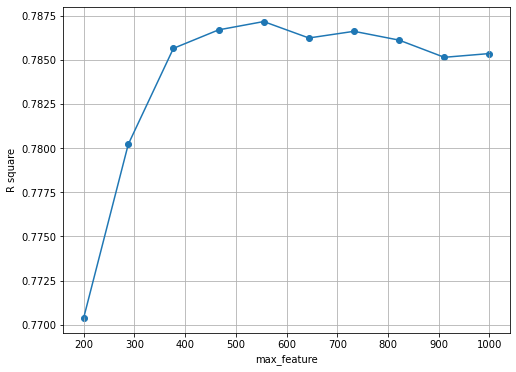

In [ ]:
#Cross validation Plot
r2_rf9 = rf_cv9.cv_results_['mean_test_score']
max_features9 = rf_cv9.cv_results_['param_max_features'].data
plt.figure(figsize = (8,6))
plt.xlabel("max_feature")
plt.ylabel("R square")
plt.scatter(max_features9, r2_rf9)
plt.plot(max_features9, r2_rf9)
plt.grid(True, which='both')
plt.show() 

In [ ]:
#Best Parameter of Cross Validation
print("This is the best parameters in random forest:", rf_cv9.best_params_)
print("This is the highest R square in Cross Validation", rf_cv9.best_score_)

This is the best parameters in random forest: {'max_depth': 30, 'max_features': 555, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 88}
This is the highest R square in Cross Validation 0.7871642133799442


In [ ]:
#Predict using Random Forest 
rf_pred9 = rf_cv9.best_estimator_.predict(X_test8)

In [ ]:
#OSR2: Evaluation of Random Forest
r2_rf9 = r2_score(y_test8, rf_pred9)
r2_rf9

0.7929177553693885